For this first trial we assume a naive model (LGM) defined as:
$$dx_t = \sigma_t dW_t^{\mathit{N}}$$

Let's define the Numeraire as:
$$N(t, x_t) = \frac{1}{B(0,t)}exp^{H_tx_t + \frac{1}{2}H_t^2\zeta_t}$$
where $H_t$ and $\zeta_t$ are known functions.

With this let's defined the fundamental equation for the pricing of a derivative under the model. The NPV (Net Present Value) is:
$$V_t = V(t, x_t)$$ 
and the deflated version 
$$\overline{V}_t = V(t, x_t) / N(t, x_t)$$

#### Montecarlo simulation

* Brownian path:
$$W_t \sim \mathcal{N}(0,t)$$
$$W[0] = X_0$$
$$W[t] = W[t - 1]  + \mathcal{Z} \cdot \Delta t^{\frac{1}{2}}$$
with 
$$\mathcal{Z} \sim \mathcal{N}(0,1)$$
* X:
$$X_{t + 1} = X_t + \sigma \cdot (W_{t + 1} - W_t)$$

In [3]:
# Regular imports 
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import math
import keras_tuner as kt
from operator import itemgetter
from scipy import stats
# Tf imports
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional

class MCSimulation():
    def __init__(self, T, N, X0, sigma, model = 'LGM'):
        self._params = {
            'T':T,
            'N':N,
            'X0':X0,
            'sigma':sigma,
        }
        self._model = model
        
    def simulate(self, nsim = 1e3, show = False):
        T, N, X0, sigma = itemgetter('T', 'N', 'X0', 'sigma')(self._params)
        nsim = int(nsim)
        dt = T / N
        # Brownian simulation
        W, X = np.zeros([N,nsim]), np.zeros([N,nsim])
        # Starting point
        W[0] = X0
        X[0] = X0
        for i in range(1, N):
            W[i] = W[i - 1] + np.random.randn(nsim) * np.sqrt(dt)
        # X simulation
        for i in range(1, N):
            X[i] = X[i - 1] + sigma * (W[i] - W[i - 1])
        if show:
            X = np.linspace(0, T, N)
        
        return X, W

In [4]:
# Strike value
Vt = 2
T = 4
# Set of parameters
T, N_steps, X0, sigma = (T, 100, 0, 0.0075)
mcsimulator = MCSimulation(T, N_steps, X0, sigma)
nsims = int(1e4)
mc_paths, W = mcsimulator.simulate(nsims)
mc_paths_flatten = mc_paths.flatten('C')
deltaTs = np.linspace(0, T, N_steps)
deltaTs = np.tile(deltaTs.reshape(N_steps, 1), nsims).flatten()
df_x = pd.DataFrame(zip(
    deltaTs,
    mc_paths_flatten
), columns = ['dt', 'xt'])

#### Visualization

In [5]:
mc_paths_transpose = mc_paths.T
deltaTs = np.linspace(0, T, N_steps)

In [6]:
if nsims < 101:
    plt.figure(figsize = (15,6))
    plt.title('Complete set of paths')
    for vect in mc_paths_transpose:
        sns.lineplot(x = deltaTs, y = vect)
    plt.show()

#### Sanity with zero bond coupon

Numeraire: 

$$N(t, x_t) = \frac{1}{D(t)}exp^{H_tx_t + \frac{1}{2}H_t^2\zeta_t}$$
where:
* $D(t)$ given and follows = $D(t) = e^{-rt}$, in this example with $r = 0.03$
* $H(t) = \frac{1 - e^{-\kappa t}}{\kappa}$, with $\kappa = 2$

Discount factor (bono cupón 0 que paga 1 en T):

$$Z(x_t, t, T) = \frac{D(T)}{D(t)}exp-((H_T - H_t)x_t - \frac{1}{2}(H_T^2-H_t^2)\zeta_t) = \frac{D(T)}{D(t)}exp(-(H_T - H_t)x_t - \frac{1}{2}H_T^2\zeta_t+\frac{1}{2}H_t^2\zeta_t) = $$
$$\frac{D(T)}{D(t)}exp(-H_Tx_t + H_tx_t - \frac{1}{2}H_T^2\zeta_t+\frac{1}{2}H_t^2\zeta_t) = \frac{D(T)}{D(t)}exp(-\frac{1}{2}H_T^2\zeta_t-H_Tx_t)exp(H_tx_t + \frac{1}{2}H_t^2\zeta_t) = $$
$$D(T)exp(-\frac{1}{2}H_T^2\zeta_t-H_Tx_t)N(t, x_t)$$
where:
* $\zeta(t) = \int_0^t\sigma^2(s)ds$, with $\sigma(s)$ a piecewise function.

The sanity aims to retrieve the $D(t)$ after aggregating for each time step $t$ on the previous simulations. Steps:
* Calculate $Z(\cdot)$ for each timestep
* Calculate the numeraire $N(\cdot)$
* Get the $\hat{D}(t)$ for each path and time step as $\hat{D}(t) = \frac{Z(\cdot)}{N(\cdot)} \to E[\hat{D}(t)] = D(t)E[exp(-\frac{1}{2}H_T^2\zeta_t-H_Tx_t)] = D(T)exp(E[-\frac{1}{2}H_T^2\zeta_t-H_Tx_t]) = D(T)$
* Aggregate and compare the value with the theoretical $D(t)$

The final objective is to check that $E[-\frac{1}{2}H_T^2\zeta_t-H_Tx_t] = 0$

In [7]:
class FinanceUtils():
    @staticmethod
    def sigma(t, sigma_0 = 0.0075):
        # Volatility function
        return sigma_0 + (t // 2) * 0.0005
    
    @staticmethod
    def C(t, sigma = sigma):
        # Zeta
        import scipy.integrate as integrate
        return integrate.quad(lambda x: sigma(x)**2, 0, t)[0]    
    @staticmethod
    @tf.function
    def zero_bond_coupon(xn, n):
        return 1.0 + xn*0.
    
class ZeroBound():    
    @staticmethod
    def D(t, r = 0.03):
        # Discount factor
        return np.exp(-r * t)
    @staticmethod
    def H(t, kappa = 2):
        # H
        return (1 - np.exp(-kappa * t)) / kappa
    @staticmethod
    def N(t, xt, ct):
        # Numeraire
        return 1/ZeroBound.D(t) * np.exp(ZeroBound.H(t) * xt + 0.5 * ZeroBound.H(t)**2 * ct)
    @staticmethod
    def Z(xt, t, T, ct = None):
        # Factor de descuento a tiempo t dado
        assert ct is not None
        return ZeroBound.D(T) * np.exp(-0.5 * ZeroBound.H(T)**2 * ct - ZeroBound.H(T)*xt) * ZeroBound.N(t, xt, ct)

In [8]:
t_unique = df_x.dt.unique()
dict_C = {dt:FinanceUtils.C(dt, sigma = FinanceUtils.sigma) for dt in t_unique}
df_x['ct'] = df_x.apply(lambda x: dict_C[x['dt']], axis = 1)
xt, t, T, ct = df_x.xt, df_x.dt, T, df_x.ct
df_x['d_hat_t'] = ZeroBound.Z(xt, t, T, ct) / ZeroBound.N(t, xt, ct)
sanity = df_x.groupby(['dt']).agg(
    d_hat_t = ('d_hat_t', 'mean')
).reset_index()
sanity['dts'] = ZeroBound.D(np.array(sorted(t_unique)))

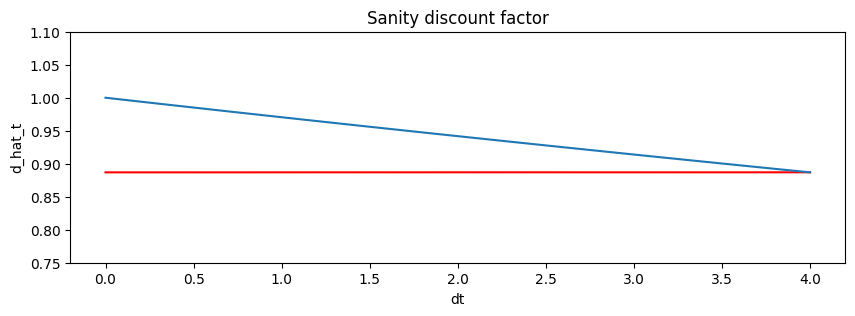

In [9]:
plt.figure(figsize = (10,3))
plt.title('Sanity discount factor')
sns.lineplot(x = 'dt', y = 'd_hat_t', data = sanity, color = 'red')
sns.lineplot(x = 'dt', y = 'dts', data = sanity)
plt.ylim(0.75, 1.1)
plt.show()

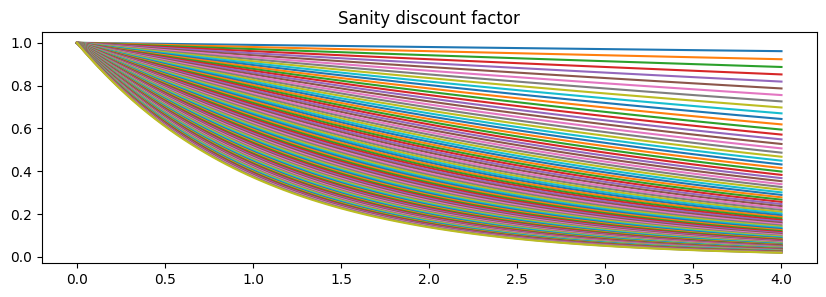

In [11]:
plt.figure(figsize = (10,3))
plt.title('Sanity discount factor')
for r in np.arange(0.01, 1.0, step = 0.01):
    sns.lineplot(x = t_unique, y = ZeroBound.D(np.array(sorted(t_unique)), r = r))
plt.show()

#### Seq2seq with feed forward neural networks

Check:
* https://towardsdatascience.com/how-to-use-custom-losses-with-custom-gradients-in-tensorflow-with-keras-e87f19d13bd5
* https://www.tensorflow.org/guide/autodiff

The idea is to include in the loss function the gradient tape to respect the model!!

In [54]:
keras.backend.clear_session() 
keras.backend.set_floatx('float64')
tf.executing_eagerly()

True

In [66]:
# TODO: Write better method definitions
class LGM_model(tf.keras.Model):
    
    def __init__(
        self,
        n_steps,
        intermediate_dim=64,
        is_sequential = False,
        name="LGM_NN_model",
        **kwargs
    ):
        super(LGM_model, self).__init__(name=name, **kwargs)
        self.N = n_steps
        input_layer = keras.Input(shape=(n_steps, ), name='input_nn')
        x = layers.Layer(trainable = False, name = 'adhoc_structure_layer')(input_layer)
        num_layer = 0
        if is_sequential:
            x = layers.GRU(intermediate_dim, name = 'sequential_layer')(x)
            num_layer += 1
        output_layer = layers.Dense(units = n_steps, activation = 'relu', name = 'first_dense')(x)
        self._custom_model = keras.Model(
            inputs=[input_layer],
            outputs=[output_layer],
            name = name
        )
        # Metrics tracker
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.mae_metric = keras.metrics.MeanAbsoluteError(name="mae")
        # Status variables
        self._grads, self._predictions = None, None
    
    @property
    def model(self):
        return self._custom_model
    
    @property
    def metrics(self):
        """_summary_

        Returns:
            _type_: _description_
        """
        return [self.loss_tracker, self.mae_metric]
    
    def summary(self):
        self._custom_model.summary()

    def call(self, inputs):
        return self.predict(inputs)
    
    @tf.function
    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            x = tf.Variable(x, trainable = True)
            v = self.predict(x)
            predictions = tf.Variable(self._predictions, trainable = False)   
            loss = self._loss_lgm(x = x, v = v, predictions = predictions, N_steps = N_steps)
        # Get trainable vars
        trainable_vars = self.trainable_weights
        grads = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(grads, trainable_vars))
        # Compute metrics
        self.loss_tracker.update_state(loss)
        # Valor erroneo
        self.mae_metric.update_state(v, y)
        return {"loss": self.loss_tracker.result(), "mae": self.mae_metric.result()}

    def _get_dv_dx(self, features):
        """_summary_

        Args:
            features (_type_): _description_

        Returns:
            _type_: _description_
        """
        xs = tf.Variable(features)
        with tf.GradientTape() as tape:
            y = self._custom_model(xs)
        # This represents dV/dX
        self._grads = tape.gradient(y, xs)
        return self._grads
    
    def _get_dv_dxi(self, i, sample_idx = None):
        return self._grads[:, i] if self._grads is not None else None
    
    # TODO: Separate from the model
    def loss_lgm(self, x: tf.Tensor, v: tf.Tensor, predictions: tf.Tensor, N_steps: np.int64):
        """_summary_

        Args:
            x (tf.Tensor): _description_
            v (tf.Tensor): _description_
            predictions (tf.Tensor): _description_
            N_steps (np.int64): _description_

        Returns:
            _type_: _description_
        """
        betas = [0.95, 0.025, 0.025]
        # Careful: Using global variable...
        len_path = N_steps
        # For f and f'
        xn = tf.Variable(x[:, -1], name = 'xn')
        n = tf.Variable(np.float64(len_path), name = 'n', trainable = False)
        n_idx = int(len_path)
        # Loss given the strike function
        strike_loss = betas[0] * (predictions[:, -1] - FinanceUtils.zero_bond_coupon(xn, n))**2
        # Autodiff f
        with tf.GradientTape() as tape:
            y = FinanceUtils.zero_bond_coupon(xn, n)
        grad_df = tape.gradient(y, {
            'xn':xn   
        })
        df_dxn = grad_df['xn'] if grad_df['xn'] is not None else 0. * xn
        # Careful: global variable
        derivative_loss = betas[1] * (self._get_dv_dxi(n_idx - 1) - df_dxn)**2
        # Epoch error per step
        error_per_step = betas[2] * tf.reduce_sum(tf.math.squared_difference(v[:, :-1], predictions[:, :-1]), axis = 1)
        
        return tf.math.add(error_per_step, tf.math.add(strike_loss, derivative_loss))

    def predict(self, X):
        """_summary_

        Args:
            X (_type_): _description_

        Returns:
            _type_: _description_
        """
        self._predictions = self._custom_model(X)
        # Keep only the first value predicted
        v = self._predictions
        # Get the gradients
        grads = self._get_dv_dx(X)
        # Do the iterative process
        for i in range(0, self.N - 1):
            v[:, i + 1] = tf.math.add(v[:, i], tf.math.multiply(grads[:, i], tf.math.subtract(X[:, i + 1], X[:, i])))
            
        return v

#### Iterative process
* F - neural network function.
* $\frac{\delta F}{\delta X_t}^i$ - gradient calculated by using the model at $i$-iteration.
* $\phi(n, x_n)$ - known terminal function.


**Path generation**
$$\hat{V} = F(X)$$

$$\overline{V}_0 = \hat{V}^i[0]$$

$$\overline{V}_{t+1} = \overline{V}_t + \frac{\delta F(X)}{\delta x_t}(x_{t + 1} - x_{t})$$

**Loss function**
$$\mathcal{L}(\overline{V}, \hat{V}) = \beta_1 \cdot (\hat{V}_n - \phi(n, x_n))^2 + \beta_2\cdot (\frac{\delta \hat{V}_n}{\delta x_n} - \frac{\delta F(X)}{\delta x_n})^2 + \sum_{i = 1}^{n - 1}(\overline{V}_i - \hat{V}_i)^2$$

$\phi(\cdot)$:
* Constant function $f(x, n) = 1$
* IRS - TODO: Check
* Swaption - TODO: Check

Experiments:
* Terminal condition 1 - static case:
    * Train the network and do the sanity against the payoff for a Zero Bound Coupon $\overline{V}(x_t,t) = \frac{Z(t, x_t, T)}{N(x_t, t)}$
    * Second detail: The NN (predict vectorized) predicts the value $\overline{V}(x_t, t)$ which is our objective

In [67]:
epochs = 1000
# Y 
y = None
# Custom model
lgm = LGM_model(N_steps, 64)
# Data used as features
x = np.reshape(mc_paths_transpose, (nsims, N_steps))
# Compile the model
lgm.compile(optimizer = 'adam')
# Fit
lgm.fit(
    x, 
    y if y is not None else np.zeros(x.shape),
    epochs = 10
)

Epoch 1/10
X: (None, 100)
Y: (None, 100)


TypeError: in user code:

    File "c:\Users\borja\Documents\GitHub\LGM_BFSDE\.venv\lib\site-packages\keras\engine\training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\borja\AppData\Local\Temp\ipykernel_68892\144722368.py", line 57, in train_step  *
        v = self.predict(x)
    File "C:\Users\borja\AppData\Local\Temp\ipykernel_68892\144722368.py", line 137, in predict  *
        v = np.zeros((samples,N))

    TypeError: 'NoneType' object cannot be interpreted as an integer


In [62]:
class CustomModel(tf.keras.Model):
    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data
        print(x.shape)
        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

In [63]:
import numpy as np

# Construct and compile an instance of CustomModel
inputs = tf.keras.Input(shape=(32,))
outputs = tf.keras.layers.Dense(1)(inputs)
model = CustomModel(inputs, outputs)
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Just use `fit` as usual
x = np.random.random((1000, 32))
y = np.random.random((1000, 1))
model.fit(x, y, epochs=3)

Epoch 1/3
(None, 32)
(None, 32)
32/32 [==============================] - 0s 1ms/step - loss: 0.6961 - mae: 0.7186
Epoch 2/3
32/32 [==============================] - 0s 2ms/step - loss: 0.2781 - mae: 0.4282
Epoch 3/3
32/32 [==============================] - 0s 2ms/step - loss: 0.2012 - mae: 0.3643


#### Sanity the NN

Once again we use the analytical solution for a ***Zero Coupon Bond***:

Numeraire: 

$$N(t, x_t) = \frac{1}{D(t)}exp^{H_tx_t + \frac{1}{2}H_t^2\zeta_t}$$
where:
* $D(t)$ given and follows = $D(t) = e^{-rt}$, in this example with $r = 0.03$
* $H(t) = \frac{1 - e^{-\kappa t}}{\kappa}$, with $\kappa = 2$

Discount factor (bono cupón 0 que paga 1 en T):

$$Z(x_t, t, T) = \frac{D(T)}{D(t)}exp-((H_T - H_t)x_t - \frac{1}{2}(H_T^2-H_t^2)\zeta_t) = \frac{D(T)}{D(t)}exp(-(H_T - H_t)x_t - \frac{1}{2}H_T^2\zeta_t+\frac{1}{2}H_t^2\zeta_t) = $$
$$\frac{D(T)}{D(t)}exp(-H_Tx_t + H_tx_t - \frac{1}{2}H_T^2\zeta_t+\frac{1}{2}H_t^2\zeta_t) = \frac{D(T)}{D(t)}exp(-\frac{1}{2}H_T^2\zeta_t-H_Tx_t)exp(H_tx_t + \frac{1}{2}H_t^2\zeta_t) = $$
$$D(T)exp(-\frac{1}{2}H_T^2\zeta_t-H_Tx_t)N(t, x_t)$$
where:
* $\zeta(t) = \int_0^t\sigma^2(s)ds$, with $\sigma(s)$ a piecewise function.

In [167]:
v, predictions = lgm.predict_path_vectorized(features)

In [207]:
v_df = pd.DataFrame(zip(v.flatten(),np.tile(np.linspace(0, T, N_steps), nsims), df_x['xt'].values.reshape(100, -1).T.flatten()), columns = ['V_hat', 'deltat', 'xt'])
t_unique = v_df.deltat.unique()
dict_C = {dt:FinanceUtils.C(dt, sigma = FinanceUtils.sigma) for dt in t_unique}
v_df['ct'] = v_df.apply(lambda x: dict_C[x['deltat']], axis = 1)

In [208]:
v_df['V'] = v_df.apply(lambda x: ZeroBound.Z(x.xt, x.deltat, T, x.ct) / ZeroBound.N(x.deltat, x.xt, x.ct), axis = 1)

In [209]:
v_df

,V_hat,deltat,xt,ct,V
0,0.000000,0.000000,0.000000,0.000000,0.886920
1,-0.003111,0.040404,0.002607,0.000002,0.885765
2,-0.001390,0.080808,0.004109,0.000005,0.885100
3,-0.002222,0.121212,0.002495,0.000007,0.885814
4,-0.002159,0.161616,0.002282,0.000009,0.885909
...,...,...,...,...,...
999995,0.007323,3.838384,0.002249,0.000230,0.885899
999996,0.005537,3.878788,0.004303,0.000233,0.884989
999997,0.006392,3.919192,0.002620,0.000235,0.885734
999998,0.005689,3.959596,0.003591,0.000238,0.885304
